In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,Flatten,LeakyReLU,Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Sequential

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install kaggle

In [0]:
!mkdir .kaggle
import json
token = {"username":#enter username,"key":#enter key}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


In [5]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [11]:
!kaggle competitions download -c facial-keypoints-detection

 78% 47.0M/60.1M [00:00<00:00, 49.2MB/s]
100% 60.1M/60.1M [00:00<00:00, 94.8MB/s]
 31% 5.00M/16.0M [00:00<00:00, 17.3MB/s]
100% 16.0M/16.0M [00:00<00:00, 40.2MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 166MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 111MB/s]


In [15]:
!unzip /content/{/content}/competitions/facial-keypoints-detection/test.zip

Archive:  /content/{/content}/competitions/facial-keypoints-detection/test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [17]:
!unzip /content/{/content}/competitions/facial-keypoints-detection/training.zip

Archive:  /content/{/content}/competitions/facial-keypoints-detection/training.zip
  inflating: training.csv            


In [22]:
train = pd.read_csv('training.csv')
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [32]:
train.isnull().any().value_counts()
#most of the columns of some null values, therefore we need to fill them

True     28
False     3
dtype: int64

In [0]:
train.fillna(method="ffill",inplace = True)
#ffill method fills the cell with the last valid value in the column

In [36]:
train.isnull().any().value_counts()

False    31
dtype: int64

In [0]:
train_img = []
images = train['Image']
for i in range(len(images)):
  img = images[i].split()
  img = ['0' if x == '' else x for x in img]
  train_img.append(img)

In [0]:
train_img = np.array(train_img,dtype='float')
X = train_img.reshape(-1,96,96,1)

In [48]:
X.shape

(7049, 96, 96, 1)

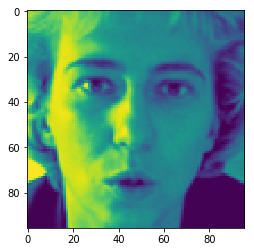

In [91]:
plt.imshow(X[1].reshape(96,96))
plt.show()

In [0]:
#getting labels
labels = train.iloc[:,:30]
labels = labels.values

In [66]:
labels.shape

(7049, 30)

In [98]:
#creating my model
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',input_shape=(96,96,1)))
model.add(Conv2D(32,(3,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32,(3,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64,(3,3),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3)))

model.add(Conv2D(128,(5,5),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128,(5,5),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(5,5)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(30))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 96, 96, 32)        9248      
__________

In [0]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae'])

In [100]:
checkpoint = ModelCheckpoint('final_model.h5',monitor='val_loss',save_best_only = True)
model.fit(X,labels,epochs = 50,batch_size = 256,validation_split = 0.2,callbacks=[checkpoint])

Train on 5639 samples, validate on 1410 samples
Epoch 1/50
5639/5639 [==============================] - 37s 7ms/step - loss: 360.3221 - mean_absolute_error: 13.6801 - val_loss: 2578.1457 - val_mean_absolute_error: 46.2276
Epoch 2/50
5639/5639 [==============================] - 31s 6ms/step - loss: 98.7589 - mean_absolute_error: 7.8276 - val_loss: 147.6841 - val_mean_absolute_error: 9.7617
Epoch 3/50
5639/5639 [==============================] - 31s 5ms/step - loss: 71.8955 - mean_absolute_error: 6.6754 - val_loss: 24.9108 - val_mean_absolute_error: 3.7634
Epoch 4/50
5639/5639 [==============================] - 31s 5ms/step - loss: 59.8215 - mean_absolute_error: 6.0601 - val_loss: 14.5497 - val_mean_absolute_error: 2.8129
Epoch 5/50
5639/5639 [==============================] - 31s 5ms/step - loss: 52.2940 - mean_absolute_error: 5.6564 - val_loss: 19.1321 - val_mean_absolute_error: 3.2975
Epoch 6/50
5639/5639 [==============================] - 31s 5ms/step - loss: 52.6924 - mean_absolute_

In [0]:
model.save_weights("model.h5")

In [108]:
np.__version__

'1.16.4'

In [0]:
import tensorflow